# CSCI-B 505 Applied Algorithms - Assignment 6

### Name : Akhila Sakiramolla (asakiram@iu.edu)
### UID : 2000886005
### Assignment partner : Keshav Likhar (klikhar)

## Importing required libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from collections import defaultdict

# To execute a cell line by line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Problem 1: Expectation-Maximization Algorithm for Clustering

Implement expectation-maximization algorithm for Gaussian mixture models (see the EM algorithm below) in Python and call this program Gk. As you present your code explain your protocol
for
1. initializing each Gaussian
2. deciding ties
3. stopping criteria

Expectation maximization is an unsupervised algorithm that can be used to calculate the hidden/latent model parameters. In this algorithm we use the existing data to determine the optimal values for these latent variables and then we update these variables iteratively.

The EM algorithm has 2 steps:


1.   Expectation step
2.   Maximization step


### 1. Initializing each Gaussian




In the expecation step, we use the existing data to initilize the mean, covariance and prior probabilities.

In [2]:
# Function to Initiliaze the mean, covariance and prior 

def initializeData(df,k):
  d = df.shape[1]
  mean_mat = df.sample(n = k).to_numpy()
  prior_prob = 1/k
  prior_prob_mat = [prior_prob]*k
  cov_mat = []
  for i in range(k):
    cov_mat.append(np.identity(d))
    
  return mean_mat, cov_mat, prior_prob_mat

### 2. Deciding ties

The deciding ties will happen when we try to the assign the data point to the original clusters but the euclidean distance between the two clusters is the same. In this case, we assign the clusters based on the data points that have high higher probability for those clusters

In [3]:
# Function to calculate posterior probability

def expectation(df_ion,k,mean,cov,prior_prob):
  n = df_ion.shape[0]
  pdf = [0]*k
  wts = [0]*k
  total_wts = [0]*n
  for i in range(k):
    pdf[i] = multivariate_normal.pdf(df_ion, mean=mean[i], cov=cov[i],allow_singular=True)
    wts[i] = pdf[i]*prior_prob[i]
    total_wts += wts[i]

  post_prob = [0]*k
  total_post_prob = [0]*n
  for i in range(k):
    post_prob[i] = wts[i]/total_wts
    total_post_prob += post_prob[i]

  return post_prob

In [4]:
# Function to re-estimate the mean, covariance and prior

def maximization(k, post_prob, df_ion):
  d = df_ion.shape[1]
  mean_updated = np.ones((k,d))
  cov_updated = []
  cov_num = []
  prior_updated = []
  for i in range(k):
    mean_updated[i] = (np.divide(np.dot(post_prob[i], df_ion), sum(post_prob[i])))
    cov_num.append(post_prob[i]*np.dot((df_ion.to_numpy() - mean_updated[i]), np.transpose(df_ion.to_numpy() - mean_updated[i])))
    cov_updated.append(cov_num[i]/sum(post_prob[i]))
    prior_updated.append(sum(post_prob[i])/df_ion.shape[0])

  return mean_updated

### 3. Stopping criteria

In maximization step, we use these initial values to calculate posterior probabilities for the clusters and update the variable values. Here we check the sum of squared errors for every iteration and return when the value converges. 

In [19]:
# Expectation maximization algorithm

def expectationMaximization(X,k):
  eps = 0.0001
  e = 1000
  error_list = []
  i = 0
  mean,cov,prior_prob = initializeData(X,k)
  while e > eps:
    post_prob = expectation(X,k,mean,cov,prior_prob)
    mean_updated = maximization(k,post_prob, X)
        
    e = np.linalg.norm(mean_updated-mean)**2

    if e <= eps:
      error_list.append(e)
      break
    mean = mean_updated
    i += 1

  return post_prob,mean_updated,error_list,i

## Problem 2: Analysis of the EM over Real-world Data Sets

Run your EM program, Gk, against the Ringnorm and Ionosphere data sets. Discuss your
results.
• Ringnorm Data Set
• Ionosphere Data Set

### Ringnorm dataset

In [53]:
# Loading data

df_ring = pd.read_csv('Dataset.data',sep = "\s+",header=None)
df_ring.shape
df_ring.head()

(7400, 21)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.8494,2.1770,0.5982,1.6894,3.1137,-3.4060,3.7986,-2.6421,1.5779,-0.1808,-0.2118,1.6327,4.6640,1.0808,-1.1717,-1.6605,0.5775,1.6638,3.0895,-3.0276,0
1,0.9471,0.5431,0.7821,-0.4493,-0.0078,1.3164,0.7556,-0.0614,1.6040,1.6859,0.2645,-0.3816,1.2591,0.6079,-2.2921,1.0078,2.6866,-1.4216,-0.6064,2.3738,1
2,0.7590,-0.3142,0.8975,-1.7429,2.0028,1.1171,0.9107,1.3603,-0.4886,-0.1444,0.9819,1.1203,0.5985,0.4741,2.0260,1.4306,-0.3357,0.7900,1.1226,0.3024,1
3,0.5306,1.3742,0.5170,1.2261,1.1218,-0.0043,-1.2268,2.2773,1.0832,0.8879,-1.1103,1.0626,2.4544,0.5873,-0.7442,1.2155,0.9163,-0.4759,0.6004,-0.4768,1
4,-1.4430,1.0651,2.0710,2.0698,-0.8647,-0.7861,2.6554,-0.3656,0.9714,-0.3410,0.2210,4.1953,-0.1172,-2.6937,0.0138,4.0970,1.3557,-0.9436,-0.6021,2.3482,0


In [54]:
X = df_ring.loc[:, df_ring.columns != 20]
X.head(2)

Y = df_ring[[20]]
Y = Y.to_numpy()

df_ring[20] = np.where(df_ring[20] == 1,'g','b')
df_ring.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.8494,2.1770,0.5982,1.6894,3.1137,-3.4060,3.7986,-2.6421,1.5779,-0.1808,-0.2118,1.6327,4.6640,1.0808,-1.1717,-1.6605,0.5775,1.6638,3.0895,-3.0276
1,0.9471,0.5431,0.7821,-0.4493,-0.0078,1.3164,0.7556,-0.0614,1.6040,1.6859,0.2645,-0.3816,1.2591,0.6079,-2.2921,1.0078,2.6866,-1.4216,-0.6064,2.3738


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.8494,2.1770,0.5982,1.6894,3.1137,-3.4060,3.7986,-2.6421,1.5779,-0.1808,-0.2118,1.6327,4.6640,1.0808,-1.1717,-1.6605,0.5775,1.6638,3.0895,-3.0276,b
1,0.9471,0.5431,0.7821,-0.4493,-0.0078,1.3164,0.7556,-0.0614,1.6040,1.6859,0.2645,-0.3816,1.2591,0.6079,-2.2921,1.0078,2.6866,-1.4216,-0.6064,2.3738,g


In [55]:
# Calculating the mean of datapoints for different classes

Y_true = df_ring[df_ring[20] == 'g']
Y_true.drop(columns = [20], inplace = True)
Y_true_mean = np.mean(Y_true).to_numpy()

Y_false = df_ring[df_ring[20] == 'b']
Y_false.drop(columns = [20], inplace = True)
Y_false_mean = np.mean(Y_false).to_numpy()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [56]:
def errorCalc(mean_updated, Y_true_mean, Y_false_mean, Y_pred, Y):
  assign={'b':[],'g':[]}
  new_predict = []
  count = 0

  for i in range(len(mean_updated)):
      if np.sum(np.linalg.norm(Y_true_mean - mean_updated[i])) < np.sum(np.linalg.norm(Y_false_mean - mean_updated[i])):
          assign['b'].append(i)
      else:
          assign['g'].append(i)

  for i in Y_pred:
      if i in assign['b']:
          new_predict.append('b')
      else:
          new_predict.append('g')
          
  for i in range(len(Y)):
      if Y[i] != new_predict[i]:
          count+=1

  error_val = count/(len(Y))
  return error_val

In [ ]:
error_list = []
iteration_list = []
error_final = []
iter_final = []

for k in range(2,6):
  # print("k:" ,k)
  error_list = []
  iteration_list = []
  for i in range(20):
    # print("iter",i)
    post_prob, mean_updated, error_list, iter_count = expectationMaximization(X, k)
    # print("iter_count:",iter_count)
    iteration_list.append(iter_count)
    # print("iteration_list:", iteration_list)

    Y_pred = np.argmax(post_prob, axis=0)

    error_val = errorCalc(mean_updated, Y_true_mean, Y_false_mean, Y_pred, Y)
    error_list.append(error_val)
      
  error_final.append(error_list)
  iter_final.append(iteration_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Text(0.5, 1.0, 'Whisker plot for Iteration Count')

Text(0.5, 0, 'Iteration count')

Text(0, 0.5, 'Number of  clusters(k)')

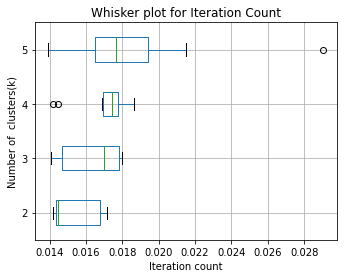

In [59]:
import matplotlib.pyplot as plt
df = pd.DataFrame(iter_final, index=[i for i in range(2,6)])
df.T.boxplot(vert=False)
plt.subplots_adjust(left=0.2)
plt.title('Whisker plot for Iteration Count')
plt.xlabel("Iteration count")
plt.ylabel("Number of  clusters(k)")
plt.show() 

Text(0.5, 1.0, 'Whisker plot for Error')

Text(0.5, 0, 'Iteration count')

Text(0, 0.5, 'Number of  clusters(k)')

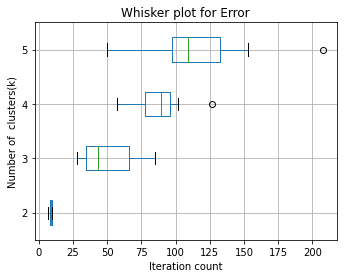

In [44]:
df = pd.DataFrame(error_final, index=[i for i in range(2,6)])
df.T.boxplot(vert=False)
plt.subplots_adjust(left=0.2)
plt.title('Whisker plot for Error')
plt.xlabel("Iteration count")
plt.ylabel("Number of  clusters(k)")
plt.show() 

### Ionosphere dataset

In [8]:
# Loading data

df_ion = pd.read_csv("ionosphere.data", header = None)
df_ion.shape
df_ion.head()

(351, 35)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,0.85243,-0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,-0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,0.50874,-0.67743,0.34432,-0.69707,-0.51685,-0.97515,0.05499,-0.62237,0.33109,-1.00000,-0.13151,-0.45300,-0.18056,-0.35734,-0.20332,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,0.73082,0.05346,0.85443,0.00827,0.54591,0.00299,0.83775,-0.13644,0.75535,-0.08540,0.70887,-0.27502,0.43385,-0.12062,0.57528,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-1.00000,0.14516,0.54094,-0.39330,-1.00000,-0.54467,-0.69975,1.00000,0.00000,0.00000,1.00000,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,0.52798,-0.20275,0.56409,-0.00712,0.34395,-0.27457,0.52940,-0.21780,0.45107,-0.17813,0.05982,-0.35575,0.02309,-0.52879,0.03286,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [9]:
X = df_ion.loc[:, df_ion.columns != 34]
X.head(2)

Y = df_ion[[34]]
Y = Y.to_numpy()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.0,0.03760,0.85243,-0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,-0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.0,-0.04549,0.50874,-0.67743,0.34432,-0.69707,-0.51685,-0.97515,0.05499,-0.62237,0.33109,-1.00000,-0.13151,-0.45300,-0.18056,-0.35734,-0.20332,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447


In [21]:
Y_true = df_ion[df_ion[34] == 'g']
Y_true.drop(columns = [34], inplace = True)
Y_true_mean = np.mean(Y_true).to_numpy()

Y_false = df_ion[df_ion[34] == 'b']
Y_false.drop(columns = [34], inplace = True)
Y_false_mean = np.mean(Y_false).to_numpy()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
error_list = []
iteration_list = []
error_final = []
iter_final = []

for k in range(2,6):
  # print("k:" ,k)
  error_list = []
  iteration_list = []
  for i in range(20):
    # print("iter",i)
    post_prob, mean_updated, error_list, iter_count = expectationMaximization(X, k)
    # print("iter_count:",iter_count)
    iteration_list.append(iter_count)
    # print("iteration_list:", iteration_list)

    Y_pred = np.argmax(post_prob, axis=0)

    error_val = errorCalc(mean_updated, Y_true_mean, Y_false_mean, Y_pred, Y)
    error_list.append(error_val)
      
  error_final.append(error_list)
  iter_final.append(iteration_list)

Text(0.5, 1.0, 'Whisker plot for Iteration Count')

Text(0.5, 0, 'Iteration count')

Text(0, 0.5, 'Number of  clusters(k)')

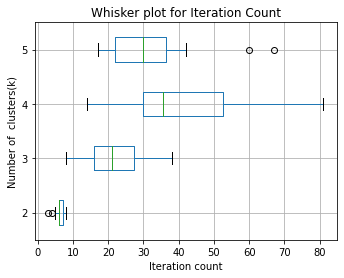

In [24]:
import matplotlib.pyplot as plt
df = pd.DataFrame(iter_final, index=[i for i in range(2,6)])
df.T.boxplot(vert=False)
plt.subplots_adjust(left=0.2)
plt.title('Whisker plot for Iteration Count')
plt.xlabel("Iteration count")
plt.ylabel("Number of  clusters(k)")
plt.show() 

Text(0.5, 1.0, 'Whisker plot for Error')

Text(0.5, 0, 'Iteration count')

Text(0, 0.5, 'Number of  clusters(k)')

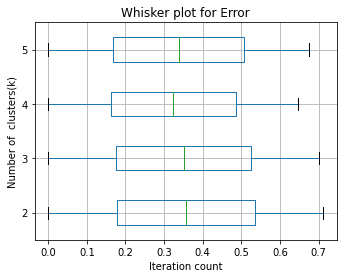

In [25]:
df = pd.DataFrame(error_final, index=[i for i in range(2,6)])
df.T.boxplot(vert=False)
plt.subplots_adjust(left=0.2)
plt.title('Whisker plot for Error')
plt.xlabel("Iteration count")
plt.ylabel("Number of  clusters(k)")
plt.show() 

## Problem 3: Algorithm Design

### Problem 3.1


Given a text D and a pattern P, describe an Ω(d+p) time method for finding the longest prefix
of P that is a substring of D. The lengths of D and P are d and p, respectively.

In [32]:
# Function to compute the fail table for pattern

def compute_kmp_fail(P) :
  # Calculating the length of pattern
  m = len(P)
  fail = [0]*m
  j = 1
  k = 0
  while j < m :
    if P[j] == P[k]:
      fail[j] = k +1
      j += 1
      k += 1
    elif k > 0:
      k = fail[k -1]
    else :
      j += 1
  return fail

In [35]:
def modifiedKMPAlgo(T, P):
  n, m = len(T), len(P)
  if m == 0:
      return 0
  fail_table = compute_kmp_fail(P)
  prefix_len = 0
  value = ""
  prefix_val = {"longest prefix": "prefix"}
  j = 0
  k = 0
  while j < n:
    if T[j] == P[k]:
      if k == m-1:
        val_return = prefix_val["longest prefix"]
        return prefix_val["longest prefix"]
      if prefix_len < k < len(P):
        prefix_len = k
        prefix_val["longest prefix"] = P[0:k+1]
        val_return = prefix_val["longest prefix"]
      j += 1
      k += 1
    elif k > 0:
      k = fail[k - 1]
    else:
      j += 1

  return prefix_val["longest prefix"]

In [37]:
# Code testing
D = 'abababsbcabask'
P = 'aba'
print("Text : ",D)
print("Pattern : ",P)
prefix = modifiedKMPAlgo(D,P)

if (prefix != "prefix"):
  print("longest matching prefix  :", prefix)

Text :  abababsbcabask
Pattern :  aba
longest matching prefix  : ab


### Problem 3.2

X, Y, and Z are three arrays and each has m elements. For an arbitrary integer t, describe
O(m2
logm)-time algorithm to determine if there exist numbers, x in X, y in Y, and z in Z, such
that t = x+y+z.

In [50]:
# Took lab code for refernce

class Node:
  def __init__(self, data, left=None, right=None):
      self.data = data
      self.left = left
      self.right = right

# define class binary tree
class BinaryTree:
    def __init__(self, data):
        self.root = Node(data)
    
    def insert(self, data):
        self.insert_by_node(self.root, data)
        return
    
    def insert_by_node(self, node, data):
        if data <= node.data:
            if node.left != None:
                self.insert_by_node(node.left, data)
            else:
                node.left = Node(data)
        else:
            if node.right != None:
                self.insert_by_node(node.right, data)
            else:
                node.right = Node(data)
                
    def contains(self, data):
        return self.contains_by_node(self.root, data)
    
    def contains_by_node(self, node, data):
        if node:
            if node.data == data:
                return True
            else:
                return self.contains_by_node(node.left, data) or self.contains_by_node(node.right, data)
        return False


def search(X, Y, Z, t):
  binary_tree = BinaryTree(Z[0])
    for ele in Z:
      binary_tree.insert(ele) 
    for x in X:
      for y in Y:
        if binary_tree.contains(t-(x+y)):
          return True
    return False

In [51]:
# code testing
X = [i for i in range(20)]
Y = [i for i in range(20)]
Z = [i for i in range(20)]

t = 20
print(search(X, Y, Z, t))

t = 100
print(search(X, Y, Z, t))

True
False


### Problem 3.3

Describe an efficient algorithm for deleting a string from a compressed trie and analyze its running time.


Algorithm for deleting a string from a compressed trie:

citation : https://www.ideserve.co.in/learn/trie-delete

1. If key is not present in trie, then we should not make any changes to the trie
2. If key is not either a prefix nor a suffix of any other key and nodes of key are not a part of any other key, then all the nodes starting from root node to leaf node of key should be deleted. 
3. If key is a prefix of some other key, then leaf node corresponding to key should be marked as 'not a leaf node'. No node should be deleted in this case.
4. If key is a suffix of some other key, then all nodes of key which are not part of the other key should be deleted.
5. If key is not a prefix nor a suffix of any other key but some nodes of key are shared with some other key, then nodes of key which are not common to any other key should be deleted and shared nodes should be kept intact.
